# Vogue Fashion Trends EDA

## Imports and Loading Data

In [25]:
# Imports
import pandas as pd
import re
import spacy
import nltk
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from collections import Counter
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Load NLP model
nlp = spacy.load("en_core_web_sm")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tesss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Load scraped data
df = pd.read_csv(r"C:\Users\tesss\OneDrive\Desktop\PersonalProjects\fashion-trends-visualization\vogue_fashion_articles_full.csv")

## Cleaning Data

In [5]:
# Function to clean and process text
def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\W+", " ", text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [6]:
# Apply cleaning
df["Cleaned_Content"] = df["Content"].apply(clean_text)
df.head()

,Title,Link,Date,Author,Content,Cleaned_Content
0,The Best Vintage Looks From the 2025 Awards Se...,https://www.vogue.com/slideshow/best-vintage-o...,"February 18, 2025",By Christian Allaire,"When you think of awards season, you likely en...",think awards season likely envision list stars...
1,The White Lotus Season 3 Fashion Is All About ...,https://www.vogue.com/article/the-white-lotus-...,"February 17, 2025",By Fawnia Soo Hoo,"Set on the picturesque island of Koh Samui, th...",set picturesque island koh samui third season ...
2,Ayo Edebiri Wore New York Fashion Week’s Risin...,https://www.vogue.com/article/ayo-edebiri-snl-...,"February 18, 2025",By Hannah Jackson,It’s no secret that Ayo Edebiri quickly ascend...,secret ayo edebiri quickly ascended one hollyw...
3,The Biggest Stars on the Front Row of London F...,https://www.vogue.com/slideshow/celebrities-fr...,"February 21, 2025",By Daisy Jones,Products are independently selected by our edi...,products independently selected editors may ea...
4,Why Are We So Obsessed With Celebrity Court St...,https://www.vogue.com/article/celebrity-court-...,"February 19, 2025",By Hannah Jackson,"Yesterday, A$AP Rocky was found not guilty in ...",yesterday ap rocky found guilty felony assault...


## Fashion Words and WordCloud

In [7]:
# Define a set of fashion-related words to keep
fashion_terms = {"dress", "runway", "trends", "designer", "fashion", "style", "wear", "outfit", "look", "vintage", "couture"}

def extract_keywords(text, top_n=20):
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    
    # Filter only fashion-related words
    filtered_words = [word for word in words if word in fashion_terms]
    
    return Counter(filtered_words).most_common(top_n)

In [8]:
# Extract keywords from all articles
all_text = " ".join(df["Cleaned_Content"].dropna())
top_keywords = extract_keywords(all_text)
print(top_keywords)

[('fashion', 680), ('dress', 562), ('look', 536), ('wear', 527), ('style', 275), ('runway', 239), ('vintage', 188), ('designer', 124), ('couture', 109), ('outfit', 93)]


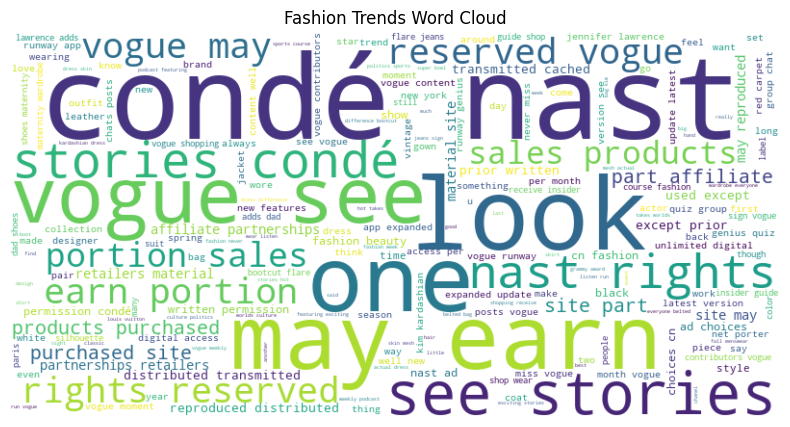

In [9]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# Plot Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Fashion Trends Word Cloud")
plt.show()

## Color Analysis

In [10]:
fashion_colors = {
    "red", "blue", "green", "yellow", "black", "white", "gray", "grey",
    "pink", "purple", "brown", "orange", "beige", "gold", "silver",
    "ivory", "maroon", "burgundy", "navy", "emerald", "teal",
    "turquoise", "lavender", "mint", "coral", "peach", "olive",
    "charcoal", "mustard", "rose", "cyan", "magenta"
}

In [12]:
# Function to count colors in each article
def count_colors(text):
    words = text.lower().split()  # Convert text to lowercase and split into words
    color_counts = Counter(word for word in words if word in fashion_colors)
    return dict(color_counts)

# Apply function to all articles
df["Color_Frequency"] = df["Content"].apply(lambda x: count_colors(x) if pd.notna(x) else {})

# Aggregate color counts across all articles
total_color_counts = Counter()
df["Color_Frequency"].apply(lambda x: total_color_counts.update(x))

# Convert to DataFrame for visualization
color_df = pd.DataFrame(total_color_counts.items(), columns=["Color", "Count"]).sort_values(by="Count", ascending=False)

# Display top colors
print(color_df.head(10))

     Color  Count
2    black    286
0      red    192
3    white    123
4     blue     57
6     gold     36
7     pink     29
1   yellow     29
10   brown     27
8   silver     20
11    gray     18


C:\Users\tesss\AppData\Local\Temp\ipykernel_1908\2946682017.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=color_df.head(15), x="Count", y="Color", palette="Blues")


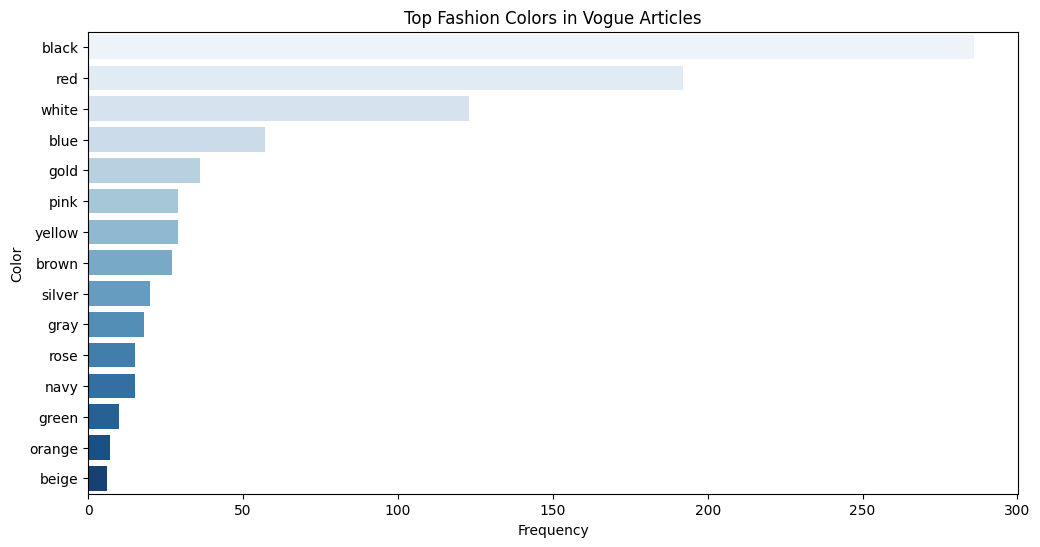

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(data=color_df.head(15), x="Count", y="Color", palette="Blues")
plt.xlabel("Frequency")
plt.ylabel("Color")
plt.title("Top Fashion Colors in Vogue Articles")

plt.show()

## Sentiment Analysis

In [15]:
# Define keywords for each category
fashion_themes = {
    "Runway Fashion": ["runway", "fashion week", "couture", "collection", "designer"],
    "Street Style": ["street style", "casual", "trendy", "urban", "influencer"],
    "Sustainability": ["sustainable", "eco-friendly", "recycled", "ethical", "carbon footprint", "slow fashion"],
    "Red Carpet": ["red carpet", "celebrity", "gala", "Met Gala", "Oscars", "Emmys"]
}

In [16]:
# Function to classify an article into a theme
def classify_article(text):
    text = text.lower()
    for theme, keywords in fashion_themes.items():
        if any(word in text for word in keywords):
            return theme
    return "Other"  # If no theme matches

# Apply classification
df["Theme"] = df["Content"].apply(lambda x: classify_article(x) if pd.notna(x) else "Other")

# Print sample classified articles
print(df[["Title", "Theme"]].head(10))

                                               Title           Theme
0  The Best Vintage Looks From the 2025 Awards Se...  Runway Fashion
1  The White Lotus Season 3 Fashion Is All About ...  Runway Fashion
2  Ayo Edebiri Wore New York Fashion Week’s Risin...  Runway Fashion
3  The Biggest Stars on the Front Row of London F...  Runway Fashion
4  Why Are We So Obsessed With Celebrity Court St...  Runway Fashion
5  Behold! Every Taylor Swift Outfit From the 202...           Other
6  Who Pays for the Wedding? A Guide to Cost-Spli...  Runway Fashion
7       The Best Vintage Stores in Dallas Fort Worth           Other
8                   The Best Vintage Stores in Milan  Runway Fashion
9               The Best Vintage Stores in São Paulo  Runway Fashion


In [19]:
# Function to get sentiment score (-1 to 1)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity if pd.notna(text) else None

# Apply sentiment analysis
df["Sentiment_Score"] = df["Content"].apply(get_sentiment)

# Aggregate sentiment by theme
sentiment_by_theme = df.groupby("Theme")["Sentiment_Score"].mean().reset_index()

# Print sentiment scores
print(sentiment_by_theme)

            Theme  Sentiment_Score
0           Other         0.165610
1      Red Carpet         0.212920
2  Runway Fashion         0.189225
3    Street Style         0.138396
4  Sustainability         0.168575


C:\Users\tesss\AppData\Local\Temp\ipykernel_1908\1435598132.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_by_theme, x="Theme", y="Sentiment_Score", palette="coolwarm")


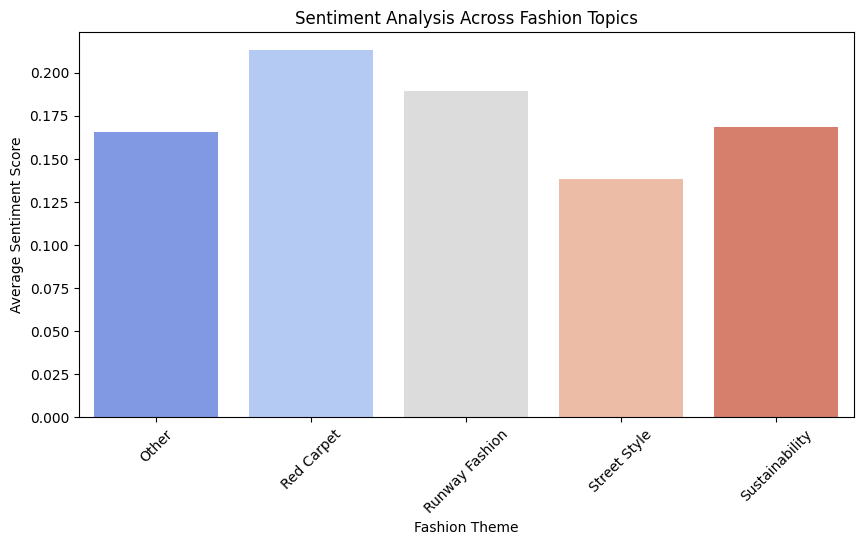

In [21]:
plt.figure(figsize=(10, 5))
sns.barplot(data=sentiment_by_theme, x="Theme", y="Sentiment_Score", palette="coolwarm")
plt.xlabel("Fashion Theme")
plt.ylabel("Average Sentiment Score")
plt.title("Sentiment Analysis Across Fashion Topics")
plt.xticks(rotation=45)

plt.show()

## Naive Bayes Classifier for Article Categories

In [22]:
# Select only the columns we need
df_sample = df[["Title", "Content"]].dropna()  # Drop rows with missing content

# Take a random sample of 50 articles
df_sample = df_sample.sample(n=50, random_state=42)

# Save to a new CSV file
df_sample.to_csv("random_50_articles.csv", index=False)

In [28]:
# Load labeled dataset
labeled_df = pd.read_csv("labeled_articles.csv")

# Drop missing values
labeled_df = labeled_df.dropna(subset=["Content", "Category"])

# Clean text (remove special characters, lowercase)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\W+", " ", text)  # Remove special characters
    return text

labeled_df["Cleaned_Content"] = labeled_df["Content"].apply(clean_text)

# Split into train & test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(labeled_df["Cleaned_Content"], labeled_df["Category"], test_size=0.2, random_state=42)

In [29]:
# Create a TF-IDF Vectorizer + Naive Bayes Model pipeline
model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("clf", MultinomialNB())  # Naive Bayes for text classification
])

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.3
              precision    recall  f1-score   support

High Fashion       0.00      0.00      0.00         4
  Red Carpet       0.14      1.00      0.25         1
  Streetwear       0.67      0.40      0.50         5

    accuracy                           0.30        10
   macro avg       0.27      0.47      0.25        10
weighted avg       0.35      0.30      0.28        10



c:\Users\tesss\OneDrive\Desktop\PersonalProjects\fashion-trends-visualization\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tesss\OneDrive\Desktop\PersonalProjects\fashion-trends-visualization\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tesss\OneDrive\Desktop\PersonalProjects\fashion-trends-visualization\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

In [31]:
# Load full dataset
df_full = pd.read_csv("vogue_fashion_articles_full.csv")
df_full["Cleaned_Content"] = df_full["Content"].apply(clean_text)

# Predict categories
df_full["Predicted_Category"] = model.predict(df_full["Cleaned_Content"])

# Save results
df_full.to_csv("vogue_articles_classified.csv", index=False)

# Print some predictions
print(df_full[["Title", "Predicted_Category"]].head(10))

                                               Title   Predicted_Category
0  The Best Vintage Looks From the 2025 Awards Se...           Red Carpet
1  The White Lotus Season 3 Fashion Is All About ...           Streetwear
2  Ayo Edebiri Wore New York Fashion Week’s Risin...           Streetwear
3  The Biggest Stars on the Front Row of London F...           Streetwear
4  Why Are We So Obsessed With Celebrity Court St...           Streetwear
5  Behold! Every Taylor Swift Outfit From the 202...           Red Carpet
6  Who Pays for the Wedding? A Guide to Cost-Spli...           Red Carpet
7       The Best Vintage Stores in Dallas Fort Worth           Streetwear
8                   The Best Vintage Stores in Milan           Streetwear
9               The Best Vintage Stores in São Paulo  Sustainable Fashion


C:\Users\tesss\AppData\Local\Temp\ipykernel_1908\241547865.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_full, x="Predicted_Category", palette="viridis")


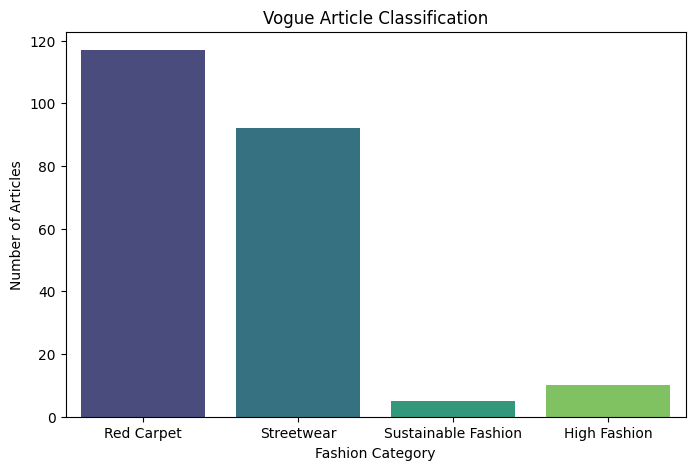

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_full, x="Predicted_Category", palette="viridis")
plt.xlabel("Fashion Category")
plt.ylabel("Number of Articles")
plt.title("Vogue Article Classification")

plt.show()